In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import gc as gc
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import timeit
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve, auc, fbeta_score, confusion_matrix, f1_score
from collections import Counter
from imblearn.over_sampling import BorderlineSMOTE

from sklearn.model_selection import KFold
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import graphviz
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from dtreeviz.trees import*

import scikitplot as skplt

from csv import DictWriter

import shap
import pickle
import pkg_resources
import json

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Import of cleaning functions
from cleaning59 import na_rows_list, na_raw_drop_df, min_row_data_rate_list, min_row_data_rate_df, column_data_rate, column_data_rate_mean, columns_not_in_list, columns_delete_df, min_column_data_rate_df, low_outlier_filter_df, high_outlier_filter_df, dic_high_outlier_filter_df, word_column_filter_df, word_column_filter_lst, sign_invert_filter_df, common_elements, separate_elements 

In [4]:
# Import of graph functions
from plotting03 import bi_joint_plot

In [5]:
# Import of ML functions
from ML20 import OneHotEncoder, label_encoding_transform_with_merge, target_encoding_transform_with_merge, vector_encoding_transform_with_merge, encoding_transform_with_merge, kfold_classif

In [6]:
# Import feature engineering module from a Kaggle script

# importing sys
import sys
  
# adding 'loan_customer_scoring' to the system path
sys.path.append('scripts\\loan_customer_scoring\\')

from data_aggregation import*

## Redefining the study case

In [7]:
smote='n'
class_weigh='n'
rfe='y'

In [8]:
# smote parameter 
if smote=='n':
    smote_case=1
    
if smote=='y':
    smote_case=2

In [9]:
# class weigh parameter 
if class_weigh=='n':
    class_weigh_case='.'
    
if class_weigh=='y':
    class_weigh_case='class_weigh_coefficient'

In [10]:
# rfe parameter 
if rfe == "y":
    rfe_case = "with_RFECV"
    
if rfe == "n":
    rfe_case = "without_RFECV"

## Folds

In [11]:
splits = 3

In [12]:
### define evaluation
folds = KFold(n_splits=splits, shuffle=True, random_state=1)

##### Choice of the loss function to optimize thresholds

### custom function

In [13]:
custom_loss='y'
fbeta=False
fbeta_number=0

## Data loading

In [14]:
if (rfe=="n"):
    
    # Data reading with path information (train)
    df_train = pd.read_csv(f'projets\\07_loan_customer_scoring\\production\\savefig\\cleaning\\df_train.csv',sep=',')

    # Data reading with path information (val)
    df_val = pd.read_csv(f'projets\\07_loan_customer_scoring\\production\\savefig\\cleaning\\df_val.csv',sep=',')

In [15]:
if (rfe=="y")&(smote=="n"):
    
    # Data reading with path information (train)
    df_train = pd.read_csv(f'projets\\07_loan_customer_scoring\\production\\savefig\\model_test_1\\feature_selection\\df_train_filtered_RFE.csv',sep=',')

    # Data reading with path information (val)
    df_val = pd.read_csv(f'projets\\07_loan_customer_scoring\\production\\savefig\\model_test_1\\feature_selection\\df_val_filtered_RFE.csv',sep=',')
 

In [16]:
if (rfe=="y")&(smote=="y"):

    # Data reading with path information (train)
    df_train = pd.read_csv(f'projets\\07_loan_customer_scoring\\production\\savefig\\model_test_2\\feature_selection\\df_train_filtered_RFE.csv',sep=',')
    
    # Data reading with path information (val)
    df_val = pd.read_csv(f'projets\\07_loan_customer_scoring\\production\\savefig\\model_test_2\\feature_selection\\df_val_filtered_RFE.csv',sep=',')


## Data transformation

In [17]:
# Defining the targets
y_train = df_train['TARGET']
y_val = df_val['TARGET']

In [18]:
# Target removal from dataframes
df_train.drop(['TARGET'], axis=1, inplace=True)
df_val.drop(['TARGET'], axis=1, inplace=True)

In [19]:
# keeping loan ID
z_train = df_train['SK_ID_CURR']
z_val = df_val['SK_ID_CURR'] 

In [20]:
# Create arrays and dataframes to store results
feats = [f for f in df_train.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]

# Modification of columns
df_train = df_train[feats]
df_val = df_val[feats]
df_train.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in df_train.columns]
df_val.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in df_val.columns]

In [21]:
X_train = df_train
X_val = df_val

In [22]:
# Data standardization
std_scale = preprocessing.StandardScaler().fit(X_train)

X_train_std = std_scale.transform(X_train)
X_val_std = std_scale.transform(X_val)

In [23]:
# Creation of a dataframe to keep the feature names
X_train_std = pd.DataFrame(X_train_std, columns=X_train.columns)
X_val_std  = pd.DataFrame(X_val_std, columns=X_val.columns)

## Function kfold_classification

In [24]:
def kfold_classif(classifier, folds, df_train_std, target_train, df_val_std, target_val, custom_loss, fbeta, fbeta_number=0, logistic_regression=False, train_resampling='n', eval_set=False,
                  scorer='auc', early_stopping_rounds=None, verbose=200):
    """K_fold training/validation for DecisionTree/RandomForest/LightGBM/XGBoost/CATBoost/LogisticRegression,
    train_resampling-> borderline smote re-sampling on the train part,
    fbetanumber-> for function to optimize"""

    """"num_iteration=clf.best_iteration_    added in the predict_proba()  """
    
# Create arrays and dataframes to store results
    crossvalid_probas = np.zeros(df_train_std.shape[0])
    valid_probas = np.zeros(df_val_std.shape[0])
    fold_AUC_list = []
    feature_importance_df = pd.DataFrame()
    feats = [f for f in df_train_std.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]

    # Modification of columns
    df_train_std_2 = df_train_std[feats]
    df_val_std_2 = df_val_std[feats]
    df_train_std_2.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in df_train_std_2.columns]
    df_val_std_2.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in df_val_std_2.columns]

    # define thresholds
    thresholds = np.arange(0, 1, 0.001)
    # apply threshold to positive probabilities to create labels
    def to_labels(pos_probs, threshold):
        return (pos_probs >= threshold).astype('int')
    
    def custom_cost_function(testy, yhat):
        # get the fn and the fp from the confusion matrix
        tn, fp, fn, tp = confusion_matrix(testy, yhat).ravel()
        # function
        y = 10*fn + fp
        return y
        
    # data from each fold
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(df_train_std_2, target_train)):
        train_x, train_y = df_train_std_2.iloc[train_idx], target_train.iloc[train_idx]
        valid_x, valid_y = df_train_std_2.iloc[valid_idx], target_train.iloc[valid_idx]   
        
        # Re-sampling 
        if train_resampling=='y':
            # summarize class distribution
            counter = Counter(train_y)
            print('Fold %2d, original distribution: ' % (n_fold + 1))
            print(counter)
            
            # transform the dataset
            oversample = BorderlineSMOTE()
            train_x, train_y = oversample.fit_resample(train_x, train_y)
            # summarize the new class distribution
            counter = Counter(train_y)
            print('Fold %2d, re-sampled distribution: ' % (n_fold + 1))
            print(counter)
     
        # classifier instance
        clf = classifier

        # fitting
        if eval_set==True:
            clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
                eval_metric=scorer, verbose=verbose, early_stopping_rounds=early_stopping_rounds)
        
        if eval_set==False:
            clf.fit(train_x, train_y)

        # validation
        crossvalid_probas[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        
        # ROC-AUC
        AUC = roc_auc_score(valid_y, crossvalid_probas[valid_idx])
        fold_AUC_list.append(AUC)

        # showing results from each fold
        print('Fold %2d AUC : %.6f' % (n_fold + 1, AUC))
           
        # Collecting results
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        
        # Classifier case
        if logistic_regression==True:
            fold_importance_df["importance"] = clf.coef_[0]
        if logistic_regression==False:
            fold_importance_df["importance"] = clf.feature_importances_
            
        fold_importance_df["fold"] = n_fold + 1
        fold_importance_df["val_fold_AUC"] = AUC
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        feature_importance_df.sort_values(by='importance', ascending=False, inplace=True)
                
        #validation_ROC_AUC = roc_auc_score(target_train, crossvalid_probas)
        valid_probas += clf.predict_proba(df_val_std, num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits      
                
        del train_x, train_y, valid_x, valid_y
        gc.collect()

    # Final performance
    mean_crossvalid_fold_ROC_AUC = sum(fold_AUC_list)/len(fold_AUC_list)
    print('Mean cross-validation ROC-AUC score %.6f' % mean_crossvalid_fold_ROC_AUC)
    
    #validation_ROC_AUC = roc_auc_score(target_train, crossvalid_probas)
    validation_ROC_AUC = roc_auc_score(target_val, valid_probas)
    print('Validation ROC-AUC score %.6f' % validation_ROC_AUC)
    
    # Optimising the threshold  
    
    if (fbeta==True)&(fbeta_number!=0):
        # evaluate each threshold with f-beta loss function
        scores = [fbeta_score(target_val.values, to_labels(valid_probas, t), average='weighted', beta=fbeta_number) for t in thresholds]
    
        # get best threshold
        ix = np.argmax(scores)
        print(f'Threshold=%.3f, F-{fbeta_number} score_max=%.5f' % (thresholds[ix], scores[ix]))
        best_score = scores[ix]
        threshold = thresholds[ix]
        
        
    if custom_loss=='y':
        # evaluate each threshold with custom loss function
        scores = [custom_cost_function(target_val.values, to_labels(valid_probas, t)) for t in thresholds]
        
        # get best threshold
        ix = np.argmin(scores)
        print(f'Threshold=%.3f, Custom loss function (10*fn + fp) score_min=%.5f' % (thresholds[ix], scores[ix]))
        best_score = scores[ix]
        threshold = thresholds[ix]
        
        
    return clf, feature_importance_df, mean_crossvalid_fold_ROC_AUC, validation_ROC_AUC, best_score, threshold
    
    

## Collection of results

In [25]:
# Creation of a dictionnary to recolt the model results
train_model_results = {}

## Final Model

### LightGBM

In [26]:
# model instance
classifier = LGBMClassifier(objective='binary', random_state=1234) 

# Timer start
start_time = timeit.default_timer()

gbm_clf, gbm_clf_importance_df, mean_crossvalid_fold_ROC_AUC, validation_ROC_AUC, best_score, threshold = kfold_classif(classifier,
                                                                                                                        folds,
                                                                                                                        X_train_std,
                                                                                                                        y_train,
                                                                                                                        X_val_std,
                                                                                                                        y_val,
                                                                                                                        custom_loss,
                                                                                                                        fbeta,
                                                                                                                        fbeta_number,
                                                                                                                        logistic_regression=False,
                                                                                                                        train_resampling=smote,
                                                                                                                        eval_set=True,
                                                                                                                        scorer='auc',
                                                                                                                        early_stopping_rounds=200,
                                                                                                                        verbose=200)

# Timer end
elapsed = timeit.default_timer() - start_time

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


Fold  1 AUC : 0.756773


'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


Fold  2 AUC : 0.756037


'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


Fold  3 AUC : 0.753354
Mean cross-validation ROC-AUC score 0.755388
Validation ROC-AUC score 0.762778
Threshold=0.088, Custom loss function (10*fn + fp) score_min=47922.00000


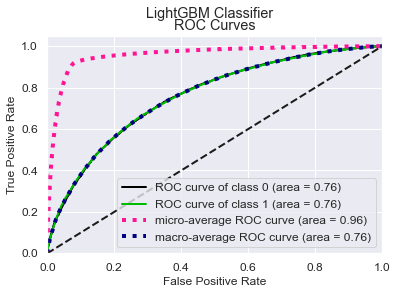

In [27]:
# ROC curve
probas = gbm_clf.predict_proba(X_val_std)
skplt.metrics.plot_roc_curve(y_val.values, probas)

# Tittle
plt.suptitle("LightGBM Classifier")

# Save
plt.savefig(f"projets\\07_loan_customer_scoring\\production\\savefig\\final_model\\model_results\\{rfe_case}\\{class_weigh_case}\\LightGBM\\roc_lightgbm.png", dpi=300)

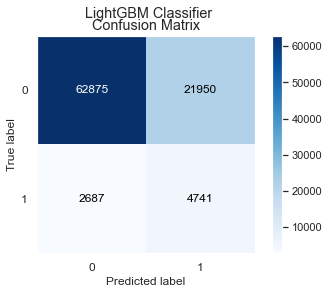

In [28]:
# Confusion matrix
y_pred = (gbm_clf.predict_proba(X_val_std)[:,1] >= threshold).astype(bool)
skplt.metrics.plot_confusion_matrix(y_val, y_pred)

# Tittle
plt.suptitle("LightGBM Classifier")

# Save
plt.savefig(f"projets\\07_loan_customer_scoring\\production\\savefig\\final_model\\model_results\\{rfe_case}\\{class_weigh_case}\\LightGBM\\confusion_matrix_lightgbm.png", dpi=300)

In [29]:
# Collecting results
train_model_results['classifier/LightGBM'] = [elapsed, mean_crossvalid_fold_ROC_AUC, validation_ROC_AUC, threshold, best_score]

#### RandomizedSearchCV

##### LightGBM bis (after RandomizedSearchCV)

In [30]:
# model instance
classifier = LGBMClassifier(
    objective='binary',
    n_estimators = 10450, # trees to build
    learning_rate = 0.017, # Multiplication performed on each boosting iteration
    max_depth = 8, # Maximum tree depth for base learners, <=0 means no limit
    num_leaves = 32, # num_leaves = 2^(max_depth)
    colsample_bytree = 0.28, # Percentage of columns used per iteration
    subsample = 0.89, # (bagging_fraction) you can specify the percentage of rows used per tree building iteration
    min_child_weight = 55,
    random_state=1234) 

# Timer start
start_time = timeit.default_timer()

gbm_clf_bis, gbm_clf_bis_importance_df, mean_crossvalid_fold_ROC_AUC, validation_ROC_AUC, best_score, threshold = kfold_classif(classifier,
                                                                                                                                folds,
                                                                                                                                X_train_std,
                                                                                                                                y_train,
                                                                                                                                X_val_std,
                                                                                                                                y_val,
                                                                                                                                custom_loss,
                                                                                                                                fbeta,
                                                                                                                                fbeta_number,
                                                                                                                                logistic_regression=False,
                                                                                                                                train_resampling=smote,
                                                                                                                                eval_set=True,
                                                                                                                                scorer='auc',
                                                                                                                                early_stopping_rounds=500,
                                                                                                                                verbose=200)

# Timer end
elapsed = timeit.default_timer() - start_time

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[200]	training's auc: 0.775487	training's binary_logloss: 0.247221	valid_1's auc: 0.749547	valid_1's binary_logloss: 0.253209
[400]	training's auc: 0.794868	training's binary_logloss: 0.238008	valid_1's auc: 0.758674	valid_1's binary_logloss: 0.248136
[600]	training's auc: 0.808358	training's binary_logloss: 0.232302	valid_1's auc: 0.761768	valid_1's binary_logloss: 0.246431
[800]	training's auc: 0.819295	training's binary_logloss: 0.227945	valid_1's auc: 0.763319	valid_1's binary_logloss: 0.245687
[1000]	training's auc: 0.828713	training's binary_logloss: 0.224217	valid_1's auc: 0.763757	valid_1's binary_logloss: 0.245447
[1200]	training's auc: 0.836985	training's binary_logloss: 0.221043	valid_1's auc: 0.763891	valid_1's binary_logloss: 0.245373
[1400]	training's auc: 0.843943	training's binary_logloss: 0.2183	valid_1's auc: 0.763851	valid_1's binary_logloss: 0.245368
[1600]	training's auc: 0.850208	training's binary_logloss: 0.215777	valid_1's auc: 0.76378	valid_1's binary_logloss: 

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[200]	training's auc: 0.776288	training's binary_logloss: 0.248037	valid_1's auc: 0.752994	valid_1's binary_logloss: 0.25167
[400]	training's auc: 0.795654	training's binary_logloss: 0.238671	valid_1's auc: 0.760587	valid_1's binary_logloss: 0.246581
[600]	training's auc: 0.808845	training's binary_logloss: 0.232961	valid_1's auc: 0.763106	valid_1's binary_logloss: 0.24497
[800]	training's auc: 0.819555	training's binary_logloss: 0.228598	valid_1's auc: 0.764032	valid_1's binary_logloss: 0.244318
[1000]	training's auc: 0.828869	training's binary_logloss: 0.224875	valid_1's auc: 0.764474	valid_1's binary_logloss: 0.244054
[1200]	training's auc: 0.836984	training's binary_logloss: 0.221764	valid_1's auc: 0.764458	valid_1's binary_logloss: 0.244008
[1400]	training's auc: 0.84381	training's binary_logloss: 0.219007	valid_1's auc: 0.764274	valid_1's binary_logloss: 0.244062
[1600]	training's auc: 0.849564	training's binary_logloss: 0.216644	valid_1's auc: 0.764111	valid_1's binary_logloss: 

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[200]	training's auc: 0.777184	training's binary_logloss: 0.247173	valid_1's auc: 0.747278	valid_1's binary_logloss: 0.253215
[400]	training's auc: 0.795928	training's binary_logloss: 0.237948	valid_1's auc: 0.756196	valid_1's binary_logloss: 0.248137
[600]	training's auc: 0.808789	training's binary_logloss: 0.232408	valid_1's auc: 0.759436	valid_1's binary_logloss: 0.246382
[800]	training's auc: 0.819522	training's binary_logloss: 0.228077	valid_1's auc: 0.760882	valid_1's binary_logloss: 0.245648
[1000]	training's auc: 0.828728	training's binary_logloss: 0.224389	valid_1's auc: 0.76154	valid_1's binary_logloss: 0.245322
[1200]	training's auc: 0.836717	training's binary_logloss: 0.221194	valid_1's auc: 0.762023	valid_1's binary_logloss: 0.245137
[1400]	training's auc: 0.84356	training's binary_logloss: 0.218467	valid_1's auc: 0.762076	valid_1's binary_logloss: 0.245069
[1600]	training's auc: 0.84934	training's binary_logloss: 0.216143	valid_1's auc: 0.762436	valid_1's binary_logloss: 

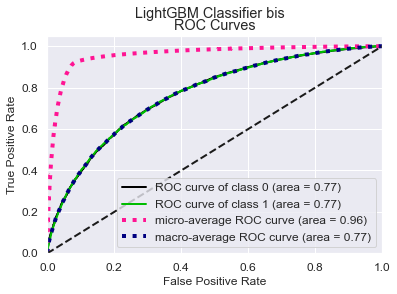

In [31]:
# ROC curve
probas = gbm_clf_bis.predict_proba(X_val_std)
skplt.metrics.plot_roc_curve(y_val.values, probas)

# Tittle
plt.suptitle("LightGBM Classifier bis")

# Save
plt.savefig(f"projets\\07_loan_customer_scoring\\production\\savefig\\final_model\\model_results\\{rfe_case}\\{class_weigh_case}\\LightGBM\\roc_lightgbm_bis.png", dpi=300)

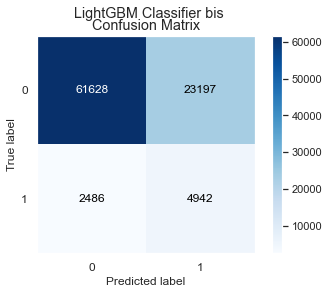

In [32]:
# Confusion matrix
y_pred = (gbm_clf_bis.predict_proba(X_val_std)[:,1] >= threshold).astype(bool)
skplt.metrics.plot_confusion_matrix(y_val, y_pred)

# Tittle
plt.suptitle("LightGBM Classifier bis")

# Save
plt.savefig(f"projets\\07_loan_customer_scoring\\production\\savefig\\final_model\\model_results\\{rfe_case}\\{class_weigh_case}\\LightGBM\\confusion_matrix_lightgbm_bis.png", dpi=300)

In [33]:
# Collecting results
train_model_results['classifier/LightGBM_bis'] = [elapsed, mean_crossvalid_fold_ROC_AUC, validation_ROC_AUC, threshold, best_score]

#### GridsearchCV

##### LightGBM - ter (after GSCV)

In [34]:
if (class_weigh=="y"):
    
    ### Class weigh
    y_train.value_counts()
    
    # Positive Binary Scaling
    pos = y_train.value_counts()[1]
    neg = y_train.value_counts()[0]
    # https://sites.google.com/view/lauraepp/parameters
    # Multiplication applied to every positive label weight.
    #By performing a weight multiplication on the positive label, the model is performing a cost-sensitive training.
    #The cost-sensitive training is applied to the booster model which impacts directly the trained models.
    #It implies a potential higher performance, especially when it comes to ranking tasks such as for AUC.
    pos_weigh_coef = neg/pos
    
else:
    pos_weigh_coef = None

In [35]:
# LightGBM instance
classifier = LGBMClassifier(
    objective='binary',
    n_estimators=10000, # trees to build
    learning_rate= 0.01, # Multiplication performed on each boosting iteration
    max_depth=10, # Maximum tree depth for base learners, <=0 means no limit
    num_leaves = 35, # num_leaves = 2^(max_depth)
    colsample_bytree = 0.3, # Percentage of columns used per iteration
    subsample = 0.1, # (bagging_fraction) you can specify the percentage of rows used per tree building iteration
    min_child_weight = 55,
    random_state=1234) 

# Timer start
start_time = timeit.default_timer()

gbm_clf_ter, gbm_clf_ter_importance_df, mean_crossvalid_fold_ROC_AUC, validation_ROC_AUC, best_score, threshold = kfold_classif(classifier,
                                                                                                                                folds,
                                                                                                                                X_train_std,
                                                                                                                                y_train,
                                                                                                                                X_val_std,
                                                                                                                                y_val,
                                                                                                                                custom_loss,
                                                                                                                                fbeta,
                                                                                                                                fbeta_number,
                                                                                                                                logistic_regression=False,
                                                                                                                                train_resampling=smote,
                                                                                                                                eval_set=True,
                                                                                                                                scorer='auc',
                                                                                                                                early_stopping_rounds=500,
                                                                                                                                verbose=200)

# Timer end
elapsed = timeit.default_timer() - start_time

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[200]	training's auc: 0.772995	training's binary_logloss: 0.250581	valid_1's auc: 0.750976	valid_1's binary_logloss: 0.255174
[400]	training's auc: 0.786032	training's binary_logloss: 0.241304	valid_1's auc: 0.758089	valid_1's binary_logloss: 0.248929
[600]	training's auc: 0.796477	training's binary_logloss: 0.236266	valid_1's auc: 0.761214	valid_1's binary_logloss: 0.246825
[800]	training's auc: 0.805469	training's binary_logloss: 0.232556	valid_1's auc: 0.762829	valid_1's binary_logloss: 0.245931
[1000]	training's auc: 0.813493	training's binary_logloss: 0.229517	valid_1's auc: 0.763636	valid_1's binary_logloss: 0.24553
[1200]	training's auc: 0.820465	training's binary_logloss: 0.226878	valid_1's auc: 0.764058	valid_1's binary_logloss: 0.245325
[1400]	training's auc: 0.827058	training's binary_logloss: 0.224431	valid_1's auc: 0.764367	valid_1's binary_logloss: 0.245192
[1600]	training's auc: 0.833315	training's binary_logloss: 0.222142	valid_1's auc: 0.764441	valid_1's binary_logloss

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[200]	training's auc: 0.771883	training's binary_logloss: 0.25142	valid_1's auc: 0.754314	valid_1's binary_logloss: 0.253891
[400]	training's auc: 0.785301	training's binary_logloss: 0.242247	valid_1's auc: 0.759924	valid_1's binary_logloss: 0.247645
[600]	training's auc: 0.79569	training's binary_logloss: 0.237265	valid_1's auc: 0.762711	valid_1's binary_logloss: 0.245499
[800]	training's auc: 0.804559	training's binary_logloss: 0.233526	valid_1's auc: 0.764092	valid_1's binary_logloss: 0.244548
[1000]	training's auc: 0.812667	training's binary_logloss: 0.230409	valid_1's auc: 0.764805	valid_1's binary_logloss: 0.244103
[1200]	training's auc: 0.819731	training's binary_logloss: 0.227729	valid_1's auc: 0.764977	valid_1's binary_logloss: 0.243955
[1400]	training's auc: 0.826394	training's binary_logloss: 0.2253	valid_1's auc: 0.765069	valid_1's binary_logloss: 0.24388
[1600]	training's auc: 0.832545	training's binary_logloss: 0.223065	valid_1's auc: 0.765087	valid_1's binary_logloss: 0.

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[200]	training's auc: 0.77397	training's binary_logloss: 0.250537	valid_1's auc: 0.74861	valid_1's binary_logloss: 0.255081
[400]	training's auc: 0.78668	training's binary_logloss: 0.241379	valid_1's auc: 0.755013	valid_1's binary_logloss: 0.249052
[600]	training's auc: 0.796678	training's binary_logloss: 0.236427	valid_1's auc: 0.758291	valid_1's binary_logloss: 0.246934
[800]	training's auc: 0.805348	training's binary_logloss: 0.232765	valid_1's auc: 0.759968	valid_1's binary_logloss: 0.246002
[1000]	training's auc: 0.813211	training's binary_logloss: 0.229739	valid_1's auc: 0.760993	valid_1's binary_logloss: 0.245534
[1200]	training's auc: 0.820105	training's binary_logloss: 0.227126	valid_1's auc: 0.76149	valid_1's binary_logloss: 0.24527
[1400]	training's auc: 0.826649	training's binary_logloss: 0.22468	valid_1's auc: 0.762031	valid_1's binary_logloss: 0.245081
[1600]	training's auc: 0.832673	training's binary_logloss: 0.222451	valid_1's auc: 0.76238	valid_1's binary_logloss: 0.24

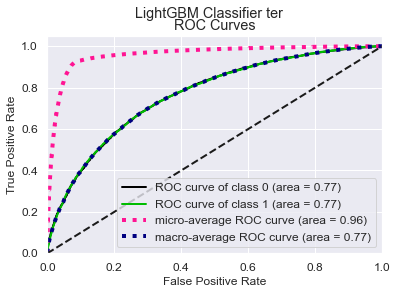

In [36]:
# ROC curve
probas = gbm_clf_ter.predict_proba(X_val_std)
skplt.metrics.plot_roc_curve(y_val.values, probas)

# Tittle
plt.suptitle("LightGBM Classifier ter")

# Save
plt.savefig(f"projets\\07_loan_customer_scoring\\production\\savefig\\final_model\\model_results\\{rfe_case}\\{class_weigh_case}\\LightGBM\\roc_lightgbm_ter.png", dpi=300)

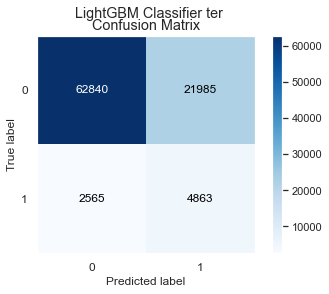

In [37]:
# Confusion matrix
y_pred = (gbm_clf_ter.predict_proba(X_val_std)[:,1] >= threshold).astype(bool)
skplt.metrics.plot_confusion_matrix(y_val, y_pred)

# Tittle
plt.suptitle("LightGBM Classifier ter")

# Save
plt.savefig(f"projets\\07_loan_customer_scoring\\production\\savefig\\final_model\\model_results\\{rfe_case}\\{class_weigh_case}\\LightGBM\\confusion_matrix_lightgbm_ter.png", dpi=300)

In [38]:
# Collecting results
train_model_results['classifier/LightGBM_ter'] = [elapsed, mean_crossvalid_fold_ROC_AUC, validation_ROC_AUC, threshold, best_score]

The performance is lower

#### Previous Hyperparameters

## Threshold

In [39]:
# define thresholds
thresholds = np.arange(0, 1, 0.001)
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

In [40]:
def custom_cost_function(testy, yhat):
        # get the fn and the fp from the confusion matrix
        tn, fp, fn, tp = confusion_matrix(testy, yhat).ravel()
        # function
        y = 10*fn + fp
        return y

In [41]:
#validation_ROC_AUC = roc_auc_score(target_train, crossvalid_probas)
valid_probas = gbm_clf_ter.predict_proba(X_val_std)[:, 1]

# evaluate each threshold with custom loss function
scores = [custom_cost_function(y_val.values, to_labels(valid_probas, t)) for t in thresholds]

# get best threshold
ix = np.argmin(scores)
print(f'Threshold=%.3f, Custom loss function (10*fn + fp) score_min=%.5f' % (thresholds[ix], scores[ix]))
best_score = scores[ix]
threshold = thresholds[ix]

Threshold=0.085, Custom loss function (10*fn + fp) score_min=47483.00000


## Prediction

In [42]:
# Prediction
y_pred =  to_labels(valid_probas, threshold)
len(y_pred)

92253

## Interpretability

### Shap

In [43]:
X_val_std.dtypes

PAYMENT_RATE                      float64
EXT_SOURCE_2                      float64
DAYS_BIRTH                        float64
EXT_SOURCE_3                      float64
AMT_ANNUITY                       float64
ANNUITY_INCOME_PERC               float64
DAYS_ID_PUBLISH                   float64
AMT_GOODS_PRICE                   float64
AMT_CREDIT                        float64
DAYS_REGISTRATION                 float64
INSTAL_DAYS_ENTRY_PAYMENT_MAX     float64
PREV_CNT_PAYMENT_MEAN             float64
DAYS_LAST_PHONE_CHANGE            float64
DAYS_EMPLOYED_PERC                float64
BURO_DAYS_CREDIT_MAX              float64
INSTAL_AMT_PAYMENT_SUM            float64
INCOME_CREDIT_PERC                float64
INSTAL_AMT_PAYMENT_MIN            float64
ACTIVE_DAYS_CREDIT_ENDDATE_MIN    float64
CLOSED_DAYS_CREDIT_MAX            float64
BURO_DAYS_CREDIT_ENDDATE_MAX      float64
APPROVED_DAYS_DECISION_MAX        float64
INSTAL_DBD_SUM                    float64
INSTAL_DBD_MAX                    

In [44]:
# explain the model's predictions using SHAP
explainer = shap.TreeExplainer(gbm_clf_ter)

In [45]:
# Sample of train dataset
sample_val = X_val_std.sample(frac=0.001, replace=True, random_state=1)
sample_val

,PAYMENT_RATE,EXT_SOURCE_2,DAYS_BIRTH,EXT_SOURCE_3,AMT_ANNUITY,ANNUITY_INCOME_PERC,DAYS_ID_PUBLISH,AMT_GOODS_PRICE,AMT_CREDIT,DAYS_REGISTRATION,...,BURO_DAYS_CREDIT_ENDDATE_MAX,APPROVED_DAYS_DECISION_MAX,INSTAL_DBD_SUM,INSTAL_DBD_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,BURO_AMT_CREDIT_SUM_MAX,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_INSTALMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_SUM,PREV_AMT_ANNUITY_MEAN
77708,-0.240825,0.511577,-0.578367,0.793909,0.379813,-0.818749,0.576469,0.371761,0.189981,-1.068030,...,-0.052879,-0.142269,1.168849,0.429809,0.219495,1.355946,0.137034,0.145681,-1.480216,-0.354042
5192,2.436540,-0.036900,0.807130,1.589505,-0.725815,-1.046810,-0.515608,-1.092441,-1.108648,-0.293485,...,-0.287439,0.199704,0.277811,-0.019195,-0.394228,0.212549,-0.239360,-0.234297,-0.343499,-0.282766
50057,-0.504396,-0.375678,0.796143,-2.121068,-0.044855,0.157699,-0.791278,0.054517,0.063867,1.098600,...,-0.308533,0.461640,3.036507,-0.260967,-0.201317,0.000644,1.903288,1.928753,-2.507437,-0.143207
73349,0.126398,-1.304820,-1.915795,0.110944,-1.174714,0.060688,-1.257797,-1.031433,-1.045306,0.029880,...,-0.343041,-0.167735,0.743466,-0.260967,0.361455,-0.322228,-0.498514,-0.495918,0.174402,-0.582298
21440,-1.133470,0.092320,-0.599654,-0.332194,-0.243676,-0.805439,0.516828,0.371761,0.588836,-0.602113,...,-0.326761,0.290654,-0.499961,-0.295506,-3.120440,-0.352530,-0.086826,-0.080310,-0.552037,-0.246069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62978,1.104512,1.270271,0.534059,-2.089771,-1.253931,-0.913069,-2.046372,-1.177853,-1.205822,-0.242755,...,-0.426616,0.076012,-0.869968,-0.986282,0.795125,-0.450390,-0.459071,-0.456099,0.688721,0.730555
63052,-0.615428,-1.351218,-0.115771,1.681477,-0.207950,-0.027168,1.921685,0.005710,0.013786,0.813778,...,-0.687544,0.317939,0.214884,-0.157350,-1.099042,-0.439694,-0.436490,-0.480999,-0.165939,-0.417796
69595,0.594115,0.096227,0.143337,0.110944,0.433246,1.221967,-1.274363,-0.238323,-0.251401,-0.511423,...,-0.328137,-0.573372,1.022860,0.775198,0.107183,-0.262260,0.085808,-0.027604,-0.176356,0.052960
30869,0.629811,0.900541,-0.910263,0.110944,-1.301462,-0.422607,-0.295603,-1.129046,-1.186539,-0.636972,...,-0.344072,1.025531,-0.316215,0.982430,0.938603,-0.234806,-0.537573,-0.535349,0.637437,-1.086236


#### Global feature importance

In [46]:
# Calculate Shap values
shap_values = explainer.shap_values(sample_val)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


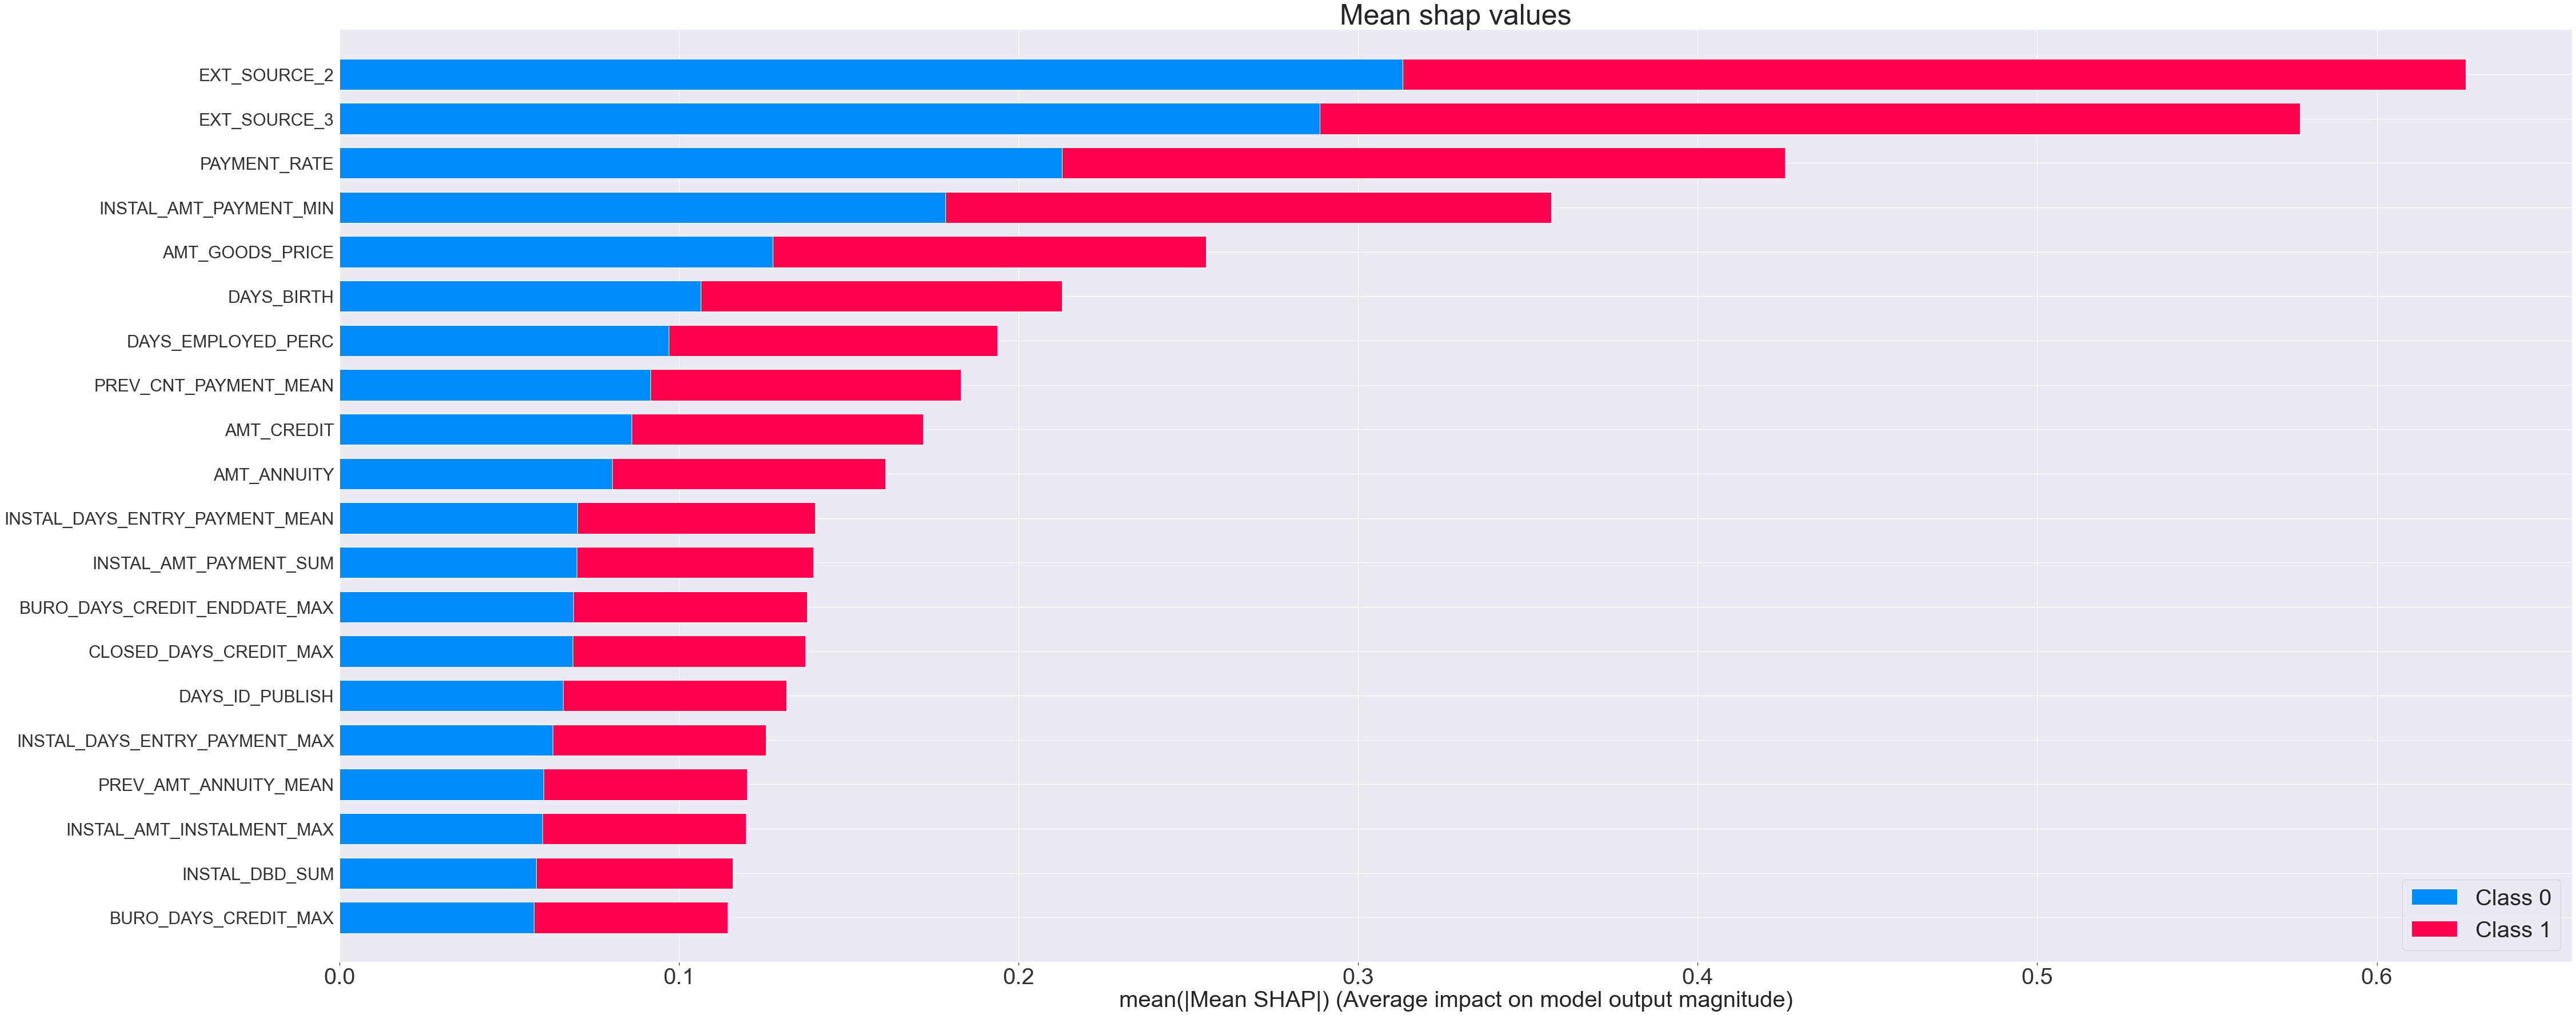

In [47]:
# Average impact
shap.summary_plot(shap_values, sample_val, show=False)

# save
fig = plt.gcf()
fig.set_size_inches(70, 30)
plt.title('Mean shap values', fontsize=50)
plt.legend(loc=4, prop={'size': 40})
plt.xticks(fontsize=40)
plt.yticks(fontsize=30)
plt.xlabel('mean(|Mean SHAP|) (Average impact on model output magnitude)', fontsize=40)
plt.savefig(f"projets\\07_loan_customer_scoring\\production\\savefig\\final_model\\model_results\\{rfe_case}\\{class_weigh_case}\\mean_shap_values.png", dpi=300, transparent=True)

In [48]:
# Force plot a sample
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], sample_val)


#### Local feature importance

In [49]:
class ShapObject:
    
    def __init__(self, base_values, data, values, feature_names):
        self.base_values = base_values # Single value
        self.data = data # Raw feature values for 1 row of data
        self.values = values # SHAP values for the same row of data
        self.feature_names = feature_names # Column names
        

In [50]:
# Plot for one customer

size = sample_val.shape[0]
row = input(f'Enter a row number from 0 to {size}: ')
row = int(row)

Enter a row number from 0 to 92:  10


##### Individual prediction

In [51]:
y_pred[row]

0

##### Shapley values

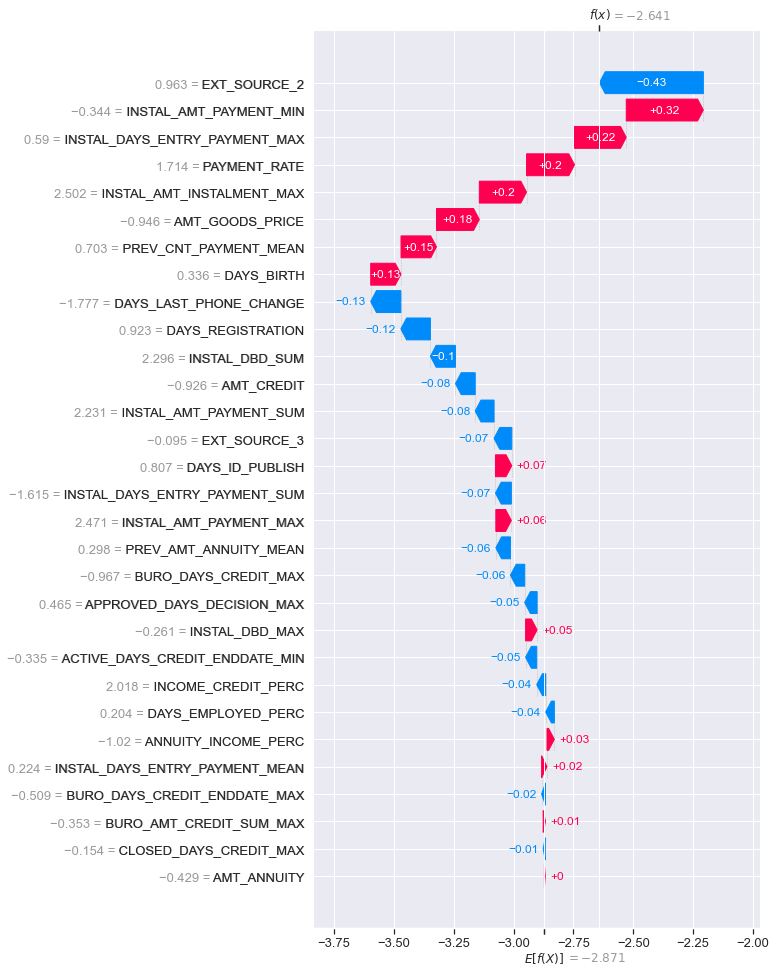

In [52]:
# Water plot
shap_object = ShapObject(base_values = explainer.expected_value[1],
                         values = explainer.shap_values(sample_val)[1][row,:],
                         feature_names = sample_val.columns,
                         data = sample_val.iloc[row,:])


shap.waterfall_plot(shap_object, max_display=30)


In [53]:
# force plot

shap.initjs()
shap.force_plot(explainer.expected_value[1], explainer.shap_values(sample_val)[1][row,:], sample_val.iloc[row,:])

# Serializing the model

In [54]:
# save the model to disk
filename = 'projets\\07_loan_customer_scoring\\production\\savefig\\final_model\model_results\\with_RFECV\\finalized_model.sav'
pickle.dump(gbm_clf_ter, open(filename, 'wb'))